In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
seed = 0
np.random.seed(seed)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-59rcaq_5 because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.



We want to automate a process to 'fake' charge jumps. 
This can be achieved by just copy pasting the whole plot at the place of the jump.
We want to randomize when to jump and where to jump.
We also want to be able to shift the template to where the last scan finished.
For simplicity, we can assume all "jumps" rewind the qubit to the original state. 
That is not what I have used bellow for various reasons, but we can assume that when making template shifts.


In [2]:
# file paths - Change to paths on your machine
basedir='/home/export/bxiao2/scratch/Downloads/NEXUS/NEXUS_Qubits/'
tomography_datapath = basedir+'Data/Tomography/'
template_datapath = basedir+'SimulatedData_Gen/Templates/'
PtbyPtoutput_datapath = basedir+'Data/PtbyPt_output/'

In [3]:
# Load templates and template sigmas (errors) for each qubit
os.chdir(str(template_datapath))

# Template data
Q1_templ = np.load('Q1_SC_templ_full.npy', allow_pickle=True)

# Error data
Q1_sigma = np.load('Q1_SC_sigma_full.npy', allow_pickle=True)

# Check data:

print("Data type:", type(Q1_templ))
print("Shape:", Q1_templ.shape)
print("Data:", Q1_templ)
print("Error:", Q1_sigma)

Data type: <class 'numpy.ndarray'>
Shape: (80,)
Data: [15.22810142 15.1837104  15.22863281 15.12636976 14.85421763 15.24081178
 15.95299722 15.66698245 15.59060545 16.08457045 16.55131686 17.30205484
 18.18520194 19.24226798 20.19999277 21.21659051 22.43865213 22.91477715
 23.37029001 23.24028777 23.31369603 22.93764836 22.23860306 20.89412519
 19.99420431 18.68686456 17.95417858 16.91558667 16.07409328 15.45946044
 14.97008279 15.16623866 15.11595045 14.46587182 14.23413493 14.25367486
 14.30768691 14.45381063 14.37051693 14.36400523 14.26122469 14.14435302
 14.22353951 14.55089071 15.50597528 14.80293838 15.00882007 15.53934336
 16.29392892 17.27073109 18.33619204 19.52055619 20.57023946 22.05491081
 22.50853748 23.37083888 23.34005468 23.64476876 23.30627275 22.6307028
 21.8899834  20.86986274 19.60277702 18.66877726 17.46089211 16.65317533
 15.81419423 15.43378053 15.17854753 16.08382932 15.11861227 14.76162505
 14.72726206 14.97957404 15.07324095 14.99371137 15.1195269  15.1661380

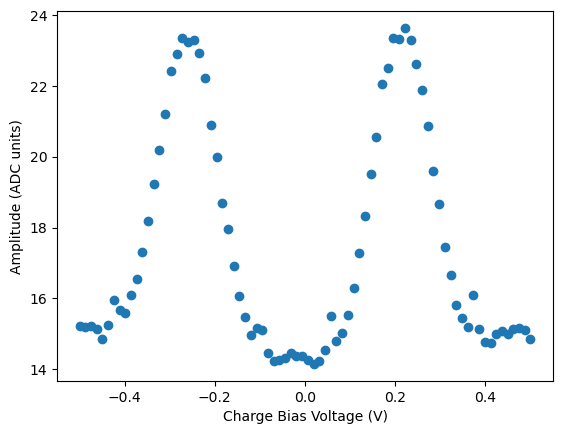

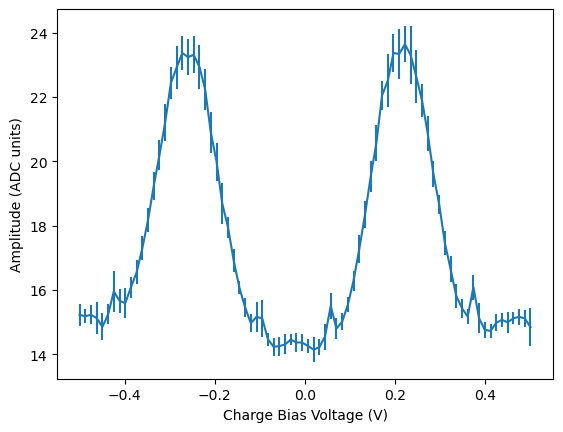

In [4]:
# Print template
# Load vsweep
os.chdir(basedir+'Data')
vsweep = np.load('vsweep.npy', allow_pickle=True)

# Plot Template with and without error - These are in ADC values
plt.scatter(vsweep, Q1_templ)
plt.xlabel("Charge Bias Voltage (V)")
plt.ylabel("Amplitude (ADC units)")
plt.show()
plt.errorbar(vsweep, Q1_templ, yerr= Q1_sigma)
plt.xlabel("Charge Bias Voltage (V)")
plt.ylabel("Amplitude (ADC units)")
plt.show()

In [5]:
# Write to txt
with open("Q1_SC_templ.txt", "w") as f:
    f.write(str(Q1_templ))
    
with open("Q1_SC_sigma.txt", "w") as f:
    f.write(str(Q1_sigma))

In [ ]:
# State Variables
# Frequency of jumps
f = 0.05

# Number of scans
n_scans = 100

# Which scan to jump
do_jump = np.random.choice([0, 1], size=n_scans, p=[1-f, f])
print(do_jump)

# Count number of jumps so far
n_jumps = np.count_nonzero(do_jump)
print(n_jumps)

In [ ]:
# Voltage index of jump: assuming maximum 1 jump per scan
n_inputs = 80
i_jump = np.random.randint(low=0, high=n_inputs-1) #generate 1 for test purposes
print(i_jump)

vi_list = np.zeros_like(do_jump)
print(vi_list)
vi_list[do_jump == 1] = np.random.randint(0, n_inputs+1, size=np.sum(do_jump == 1))
print(vi_list[do_jump==1])

# Count amount of displacement so far

cum_jumps = np.count_nonzero(vi_list) % n_inputs
print(cum_jumps)


In [ ]:
# If has jump
# Make new ndarr with jump
rep = 0
Q1_longtempl = np.tile(Q1_templ, 2)  # repeat template 2 times
if i_jump <= 30: #make sure the "jump" is different than the original
    rep = 35
# Part before jump
part1 = Q1_longtempl[:i_jump]

# Jump once
part2 = Q1_longtempl[rep:rep+n_inputs-i_jump]  

# Combine them
Q1_jump = np.concatenate([part1, part2])

print(Q1_jump)

Need to make this a function: when do_jump[scan #] = 1
input: template SHIFTED, scan #, i_jump[scan #] 
output: scan W/ JUMP


In [ ]:
# Print new data
# Load vsweep
os.chdir(basedir+'Data')
vsweep = np.load('vsweep.npy', allow_pickle=True)

# Plot without error
plt.plot(vsweep, Q1_templ, color='blue', label='Template')
plt.plot(vsweep, Q1_jump, color='green', label='With Jump')
plt.xlabel("Charge Bias Voltage (V)")
plt.ylabel("Amplitude (ADC units)")
plt.legend() 
plt.show()

In [ ]:
#if do_jump==1, call function and apply jump on the n-th scan at the i-jump
def apply_jump(scan, i_jump):
    rep=0
    #repeat template 2 times
    Q1_longtempl = np.tile(scan, 2) 
    #avoid early (or too late!) jumps
    if i_jump <= 20 or i_jump>=70: 
        rep = 35
    #before jump
    part1 = Q1_longtempl[:i_jump]
    #after jump
    part2 = Q1_longtempl[rep:rep+len(scan)-i_jump] 
    #combine them
    scan = np.concatenate([part1, part2])
    return scan

In [ ]:
"""""
f = 0.1
n_inputs = 80
n_scans = 30

#read n scans
scans =  [np.load(file, allow_pickle=True) for file in sorted(glob.glob(os.path.join(template_datapath, '*.npy')))[:n_scans]]

#randomly apply jumps to scans
do_jump = np.random.choice([0, 1], size=n_scans, p=[1-f, f])
#create vi_list to randomly assign point where jump will happen
vi_list = np.zeros_like(do_jump)
vi_list[do_jump == 1] = np.random.randint(0, n_inputs+1, size=np.sum(do_jump == 1))
#loop over i scans where jump happens and call apply_jump function
print(vi_list)
Q1_templ = scans[np.nonzero(vi_list)[0][0]][:n_inputs]
for i in np.nonzero(vi_list)[0]:
    i_jump = vi_list[i]
    scan_jump = apply_jump(scans[i], i_jump)
    scans[i] = scan_jump
    print("Applied jump to scan ", i)
Q1_jump = scans[np.nonzero(vi_list)[0][0]][:n_inputs]

# Print new data
# Load vsweep
os.chdir(basedir+'Data')
vsweep = np.load('vsweep.npy', allow_pickle=True)

# Plot without error
plt.plot(vsweep, Q1_templ, color='blue', label='Template')
plt.plot(vsweep, Q1_jump, color='green', label='With Jump')
plt.xlabel("Charge Bias Voltage (V)")
plt.ylabel("Amplitude (ADC units)")
plt.legend() 
plt.show()
"""

In [ ]:
f = 1
n_inputs = 80
n_scans = 30

# Read ONLY templates with 'templ_full' in the filename
all_files = sorted(glob.glob(os.path.join(template_datapath, '*templ_full*.npy')))
all_scans = [np.load(file, allow_pickle=True) for file in all_files]

print(f"Total scans available (templ_full only): {len(all_scans)}")
print(f"Using n_scans: {n_scans}")

# Check if we have enough scans
if n_scans > len(all_scans):
    print(f"Warning: Requested {n_scans} scans but only {len(all_scans)} available!")
    n_scans = len(all_scans)

# Select n_scans from all available scans
scans = all_scans[:n_scans]

# Save original scans for comparison
import copy
scans_original = copy.deepcopy(scans)

# Randomly apply jumps to scans
do_jump = np.random.choice([0, 1], size=n_scans, p=[1-f, f])

# Create vi_list to randomly assign point where jump will happen
vi_list = np.zeros_like(do_jump)
vi_list[do_jump == 1] = np.random.randint(0, n_inputs+1, size=np.sum(do_jump == 1))

print(f"vi_list: {vi_list}")
print(f"Number of jumps: {np.sum(do_jump)}")

# Check if any jumps exist
if not np.any(vi_list):
    print("No jumps were generated! Increase f or n_scans.")
else:
    # Loop over scans where jump happens and apply jump
    jump_indices = np.nonzero(vi_list)[0]
    
    for i in jump_indices:
        i_jump = vi_list[i]
        scans[i] = apply_jump(scans[i], i_jump)
        print(f"Applied jump to scan {i} at voltage index {i_jump}")
    
    # Plot the first scan that had a jump
    first_jump_idx = jump_indices[0]
    Q1_template = scans_original[first_jump_idx][:n_inputs]
    Q1_jump = scans[first_jump_idx][:n_inputs]
    
    # Load vsweep
    os.chdir(basedir + 'Data')
    vsweep = np.load('vsweep.npy', allow_pickle=True)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(vsweep, Q1_template, color='blue', label='Original Template', linewidth=2)
    plt.plot(vsweep, Q1_jump, color='red', label='With Jump', linewidth=2, alpha=0.7)
    plt.axvline(vsweep[int(vi_list[first_jump_idx])], color='green', linestyle='--', 
                label=f'Jump at V={vsweep[int(vi_list[first_jump_idx])]:.2f}V')
    plt.xlabel("Charge Bias Voltage (V)", fontsize=12)
    plt.ylabel("Amplitude (ADC units)", fontsize=12)
    plt.title(f"Scan {first_jump_idx}: Jump at voltage index {int(vi_list[first_jump_idx])}", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
import glob
import numpy as np
import os
from collections import defaultdict
import matplotlib.pyplot as plt

# Step 1: Load all templates
all_files = sorted(glob.glob(os.path.join(template_datapath, '*templ_full*.npy')))

print(f"Total template files found: {len(all_files)}")
print("="*80)

# Organize templates by qubit and state (SC/SO)
templates = defaultdict(lambda: defaultdict(list))

for file in all_files:
    filename = os.path.basename(file)
    
    # Parse filename: Q1_SC_templ_full.npy
    parts = filename.split('_')
    
    if len(parts) >= 2:
        qubit = parts[0]  # Q1, Q2, Q3, Q4
        state = parts[1]  # SC (closed) or SO (open)
        
        # Load the template
        template = np.load(file, allow_pickle=True)
        
        templates[qubit][state].append({
            'filename': filename,
            'filepath': file,
            'data': template
        })
        
        print(f"Loaded: {filename} -> Qubit: {qubit}, State: {state}, Shape: {template.shape}")

# Step 2: Load vsweep
os.chdir(basedir + 'Data')
vsweep = np.load('vsweep.npy', allow_pickle=True)

# Step 3: Plot everything
qubits = sorted(templates.keys())
states = ['SC', 'SO']  # Closed and Open

# Create subplots - 2 rows (SC/SO) x N columns (qubits)
n_qubits = len(qubits)
fig, axes = plt.subplots(2, n_qubits, figsize=(5*n_qubits, 8))

# Handle case of single qubit
if n_qubits == 1:
    axes = axes.reshape(2, 1)

for col, qubit in enumerate(qubits):
    for row, state in enumerate(states):
        ax = axes[row, col]
        
        if state in templates[qubit] and len(templates[qubit][state]) > 0:
            # Get template data
            template_data = templates[qubit][state][0]['data']
            
            # Plot (use first n_inputs points if template is longer)
            plot_data = template_data[:len(vsweep)] if len(template_data) > len(vsweep) else template_data
            plot_vsweep = vsweep[:len(plot_data)]
            
            ax.plot(plot_vsweep, plot_data, linewidth=2, color='blue' if state == 'SC' else 'red')
            ax.set_title(f'{qubit} {state} ({"Closed" if state == "SC" else "Open"})', fontsize=12, fontweight='bold')
            ax.set_xlabel('Charge Bias Voltage (V)', fontsize=10)
            ax.set_ylabel('Amplitude (ADC units)', fontsize=10)
            ax.grid(True, alpha=0.3)
            
            # Add info text
            info_text = f'Shape: {template_data.shape}\nFile: {templates[qubit][state][0]["filename"]}'
            ax.text(0.02, 0.98, info_text, transform=ax.transAxes, 
                   fontsize=8, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        else:
            ax.text(0.5, 0.5, f'{qubit} {state}\nNot Available', 
                   ha='center', va='center', transform=ax.transAxes, fontsize=12)
            ax.set_xlabel('Charge Bias Voltage (V)', fontsize=10)
            ax.set_ylabel('Amplitude (ADC units)', fontsize=10)

plt.tight_layout()
plt.suptitle('All Qubit Templates: SC (Closed) vs SO (Open)', fontsize=16, fontweight='bold', y=1.00)
plt.subplots_adjust(top=0.96)
plt.show()

# Overlay plots
fig2, axes2 = plt.subplots(1, n_qubits, figsize=(5*n_qubits, 5))

if n_qubits == 1:
    axes2 = [axes2]

for col, qubit in enumerate(qubits):
    ax = axes2[col]
    
    # Plot SC (closed)
    if 'SC' in templates[qubit] and len(templates[qubit]['SC']) > 0:
        template_data = templates[qubit]['SC'][0]['data']
        plot_data = template_data[:len(vsweep)]
        plot_vsweep = vsweep[:len(plot_data)]
        ax.plot(plot_vsweep, plot_data, linewidth=2, color='blue', label='SC (Closed)', alpha=0.7)
    
    # Plot SO (open)
    if 'SO' in templates[qubit] and len(templates[qubit]['SO']) > 0:
        template_data = templates[qubit]['SO'][0]['data']
        plot_data = template_data[:len(vsweep)]
        plot_vsweep = vsweep[:len(plot_data)]
        ax.plot(plot_vsweep, plot_data, linewidth=2, color='red', label='SO (Open)', alpha=0.7)
    
    ax.set_title(f'{qubit}: SC vs SO', fontsize=14, fontweight='bold')
    ax.set_xlabel('Charge Bias Voltage (V)', fontsize=12)
    ax.set_ylabel('Amplitude (ADC units)', fontsize=12)
    ax.legend(fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
#make new template to begin where last iteration end

def new_templ(templ, i_jump, rep, n_inputs):
    
    #make sure new template have the same length
    new_templ = np.empty_like(templ)
    
    #set each point 
    i=0
    while i<n_inputs:
        new_templ[i] = templ[(i+i_jump-rep)%n_inputs]
        i += 1
    
    #return
    return new_templ
    

In [ ]:
#check above
print("Data:", Q1_templ)
print("Shift:", i_jump-rep)
Q1_ntempl = new_templ(Q1_templ, i_jump, rep, n_inputs)
print("New Data:", Q1_ntempl)

In [ ]:
# Print new data
# Load vsweep
os.chdir(basedir+'Data')
vsweep = np.load('vsweep.npy', allow_pickle=True)

#print plot
plt.plot(vsweep, Q1_templ, color='blue', label='Template')
plt.plot(vsweep, Q1_ntempl, color='green', label='Template Shifted')
plt.xlabel("Charge Bias Voltage (V)")
plt.ylabel("Amplitude (ADC units)")
plt.legend() 
plt.show()